In [94]:
import pandas as pd
import numpy as np
from scipy.signal import convolve, gaussian
import matplotlib.pyplot as plt 
from prophet import Prophet
import cmdstanpy
from tqdm import tqdm
cmdstanpy.utils.get_logger().setLevel('ERROR')

In [95]:
precip_meas_data = pd.read_parquet("data/weather_precip_past1min.par").set_index("time")
precip_meas_data.index = pd.to_datetime(precip_meas_data.index).tz_localize(None)
precip_meas_data = precip_meas_data.resample("60min").sum()
precip_for_data = pd.read_csv("data/weather_precip_forecast.csv", usecols=[0, 1])
precip_for_data.columns = ['time', 'precip_for']
precip_for_data["time"] = pd.to_datetime(precip_for_data["time"])
precip_for_data = precip_for_data.set_index("time")
inflow_data = pd.read_parquet("data/raw_data_inflow.par")
inflow_data = inflow_data.set_index("time").tz_localize(None)


In [96]:
data = precip_for_data.join(precip_meas_data).join(inflow_data).dropna()
data = data.reset_index()

In [97]:
decay_rate = 0.5
kernel = np.exp(-decay_rate * np.arange(2))

data["precip_con"] = convolve(data["precip_past1min"], kernel, mode='same')
data["precip_for"] = convolve(data["precip_for"], kernel, mode='same')
data["precip"] = data["precip_past1min"]

In [98]:
data = data.rename(columns={"inflow":"y", "time":"ds"})
data["ds"] = data["ds"].dt.tz_localize(None)

In [99]:
holiday_df = data[data['precip_past1min'] > 0][['ds']]
holiday_df['holiday'] = 'rainy_day'
holiday_df['lower_window'] = 0
holiday_df['upper_window'] = 1

In [112]:
import pandas as pd
from prophet import Prophet
from sklearn.preprocessing import StandardScaler

def create_enhanced_prophet_model(data, window_size=1500, n_steps_ahead=24, holiday_df=None):
    results = None
    forecasted_values = []
    
    # Create additional features for precipitation
    data = data.copy()
    data['precip_squared'] = data['precip_con'] ** 2
    data['precip_cumsum'] = data['precip_con'].rolling(window=24).sum()
    data['precip_binary'] = (data['precip_con'] > 0).astype(int)

    
    # Scale the features
    scaler = StandardScaler()
    precip_features = ['precip_con', 'precip_squared', 'precip_cumsum']
    
    # Store original values before scaling
    original_features = data[precip_features].copy()
    
    # Fit and transform the data
    data[precip_features] = scaler.fit_transform(data[precip_features])
    data = data.dropna()
    
    all_forecasts = []
    
    for start in tqdm(range(0, len(data) - window_size + 1, n_steps_ahead)):
        model = Prophet(
            seasonality_mode='multiplicative',
            changepoint_prior_scale=25,
            seasonality_prior_scale=10,
            daily_seasonality=True,
            weekly_seasonality=True
        )
        
        model.add_regressor('precip_con', prior_scale=90)
        model.add_regressor('precip_squared', prior_scale=90)
        model.add_regressor('precip_cumsum', prior_scale=20)
        model.add_regressor('precip_binary', prior_scale=20)

        
        model.add_seasonality(
            name='precipitation_seasonality',
            period=1,
            fourier_order=5,
            prior_scale=20
        )
        
        training_data = data[start:start + window_size].copy()
        results = model.fit(training_data)
        
        future = model.make_future_dataframe(
            periods=n_steps_ahead,
            include_history=False,
            freq='h'
        )
        
        future_slice = data.loc[start + window_size:start + window_size + n_steps_ahead - 1]
        for feature in ['precip_con', 'precip_squared', 'precip_cumsum', 'precip_binary']:
            future[feature] = future_slice[feature].values
        
        forecast = model.predict(future)
        
        original_indices = data.index[start + window_size:start + window_size + n_steps_ahead]
        
        forecast['original_precip'] = original_features.loc[original_indices, 'precip_con'].values
        forecast['original_precip_squared'] = original_features.loc[original_indices, 'precip_squared'].values
        forecast['original_precip_cumsum'] = original_features.loc[original_indices, 'precip_cumsum'].values
        
        forecast['scaled_precip'] = future_slice['precip_con'].values
        forecast['y'] = future_slice['y'].values
        
        all_forecasts.append(forecast)
        
        if start == 24*30:
            break
    
    final_forecasts = pd.concat(all_forecasts).reset_index(drop=True)
    final_forecasts.attrs['scaler'] = scaler
    
    return final_forecasts

def unscale_features(forecasted_df, feature_names):

    scaler = forecasted_df.attrs['scaler']
    scaled_values = forecasted_df[feature_names].values
    unscaled_values = scaler.inverse_transform(scaled_values)
    
    result = forecasted_df.copy()
    for i, feature in enumerate(feature_names):
        result[f'unscaled_{feature}'] = unscaled_values[:, i]
    
    return result

# Example usage:
forecasted_values = create_enhanced_prophet_model(data, holiday_df=holiday_df)

# Unscale specific features
unscaled_forecasts = unscale_features(forecasted_values, 
                                    ['precip_con', 'precip_squared', 'precip_cumsum'])

 14%|█▎        | 30/220 [00:18<01:58,  1.60it/s]


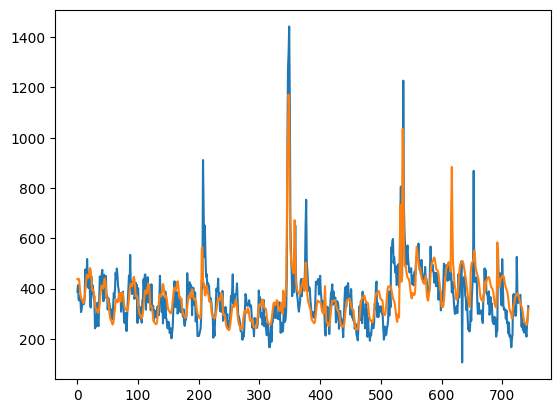

In [113]:
plt.plot(forecasted_values["y"])
plt.plot(forecasted_values["yhat"])

In [130]:
pd.DataFrame(forecasted_values[["yhat", "y"]]).to_parquet("forecast_df.par")